# Shape Interpolation

In [1]:
from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 

from scipy.ndimage import gaussian_filter

## Define Marginals

In [2]:
def sharpen(img):
    blurred = gaussian_filter(img, sigma=7)
    
    blurred[blurred<0.5*np.max(blurred)] = 0.0
    blurred[blurred>0] = 1.0

    blurred /= np.sum(blurred)
    return blurred

def pad(img,pad_size=4):
    temp = np.ones((img.shape[0]+2*pad_size,img.shape[1]+2*pad_size))
    temp[pad_size:-pad_size,pad_size:-pad_size] = img
    return temp

def rescale(img):
    output = np.zeros((2*img.shape[0],2*img.shape[1]))
    output[0::2,0::2] = img 
    output[1::2,0::2] = img 
    output[1::2,1::2] = img 
    output[0::2,1::2] = img 

    return output

#### Load and rescale images

In [3]:
measures = [None]*4
measures[0] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/redcross.png')[:, :, 2])))))
measures[1] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/tooth.png')[:, :, 2])))))
measures[2] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/heart.png')[:, :, 2])))))
measures[3] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/duck.png')[:, :, 2])))))

for i in range(len(measures)):
    measures[i] *= np.prod(measures[i].shape)/np.sum(measures[i])
   
print('Marginal size = ', measures[0].shape)

Marginal size =  (1088, 1088)


### Normalize images to create measures

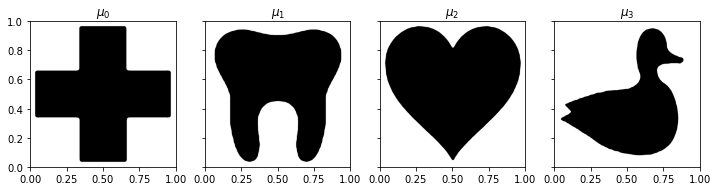

In [4]:
# Grid of size n1 x n2
n1,n2 = measures[0].shape

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

# Normalize all the measures
for i in range(len(measures)):
    measures[i] *= n1*n2 / np.sum(measures[i])

#### Plot the measures

In [ ]:
fig, ax = plt.subplots(1, len(measures), figsize=(12,4),sharey=True)
for i in range(len(measures)):
    ax[i].imshow(measures[i], extent=(0,1,0,1), cmap='Greys')
    ax[i].set_title("$\\mu_{{ {:0d} }}$".format(i))

## Solve for Each Barycenter

In [5]:
def SolveForBary(bary_weights):
    unroll_node = 1
    bary_weights /= np.sum(bary_weights)

    # Only keep the measures with positive weights
    keep_inds = np.where(bary_weights>0)[0]
    bary_weights = bary_weights[keep_inds]
    if(len(keep_inds)==1):
        return measures[keep_inds[0]]
    
    keep_measures = [measures[i] for i in keep_inds]

    # Construct the edge list for the barycenter problem
    edge_list = []
    for i in range(len(keep_inds)):
        for j in range(i+1,len(keep_inds)):
            edge_list.append([i,j])

    # Set up the MMOT solver
    prob = MMOTSolver(keep_measures, edge_list, x, y, unroll_node, bary_weights)
    
    # Solve the MMOT problem
    res = prob.Solve(max_its=1000, step_size=1.0, ftol_abs=1e-11, gtol_abs=1e-7, max_line_its=30)
    
    # Use the result to compute the barycenter
    return prob.Barycenter(res.dual_vars)

Iteration, StepSize,    Cost,     Error,  Line Its
        0,   0.1250,  1.1400e-03,   1.7696e-02,         3
       10,   0.0967,  1.3100e-03,   3.7211e-06,         0
       20,   0.0749,  1.3104e-03,   9.2093e-07,         0
       30,   0.0580,  1.3105e-03,   3.2095e-07,         1
       40,   0.0897,  1.3105e-03,   2.0714e-07,         0
       50,   0.0347,  1.3106e-03,   1.5229e-07,         0
       60,   0.0537,  1.3106e-03,   1.4505e-07,         0
       64,   0.0279,  1.3106e-03,   1.3943e-07,         0
Terminating due to small change in objective.
Iteration, StepSize,    Cost,     Error,  Line Its
        0,   0.2500,  9.8191e-04,   1.7696e-02,         2
       10,   0.0967,  1.7466e-03,   7.9338e-06,         0
       20,   0.1498,  1.7472e-03,   8.9044e-07,         0
       30,   0.0580,  1.7473e-03,   2.8863e-07,         1
       40,   0.0449,  1.7474e-03,   1.8985e-07,         0
       50,   0.0694,  1.7474e-03,   1.5930e-07,         0
       60,   0.1075,  1.7474e-03,   1.38

KeyboardInterrupt: 

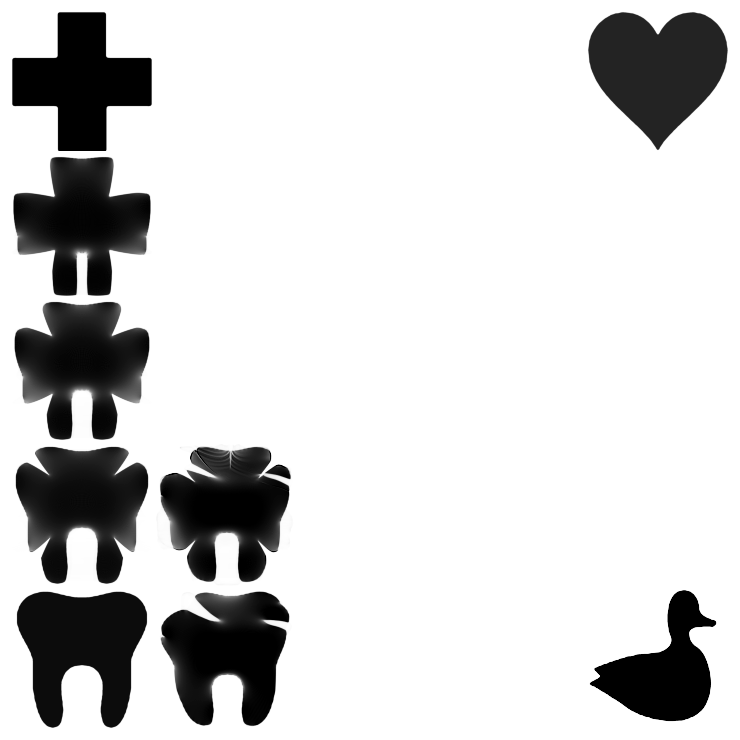

In [6]:
fig=plt.figure(figsize=(8,8)) 

vmax = np.max(measures[0])

size=0.26
corner_pos = np.array([[0.0,1.0], [0.0,0.0], [1.0,1.0], [1.0,0.0]])

for i,m in enumerate(measures):
    ax=fig.add_axes([corner_pos[i,0],corner_pos[i,1],size,size])
    ax.imshow(measures[i],extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
    ax.set_axis_off()

for w1 in np.linspace(0,1,5):
    for w2 in np.linspace(0,1,5):
        weights = [(1.0-w1)*w2, (1.0-w1)*(1.0-w2), w1*w2, w1*(1.0-w2)]
        if(np.max(weights)<1.0-1e-12):
            avg_pos = [w1,w2]
            
            bary = SolveForBary(weights)

            ax=fig.add_axes([avg_pos[0],avg_pos[1],size,size])
            ax.imshow(bary,extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
            ax.set_axis_off()
            
plt.savefig('ShapeInterpolation.pdf',bbox_inches='tight')